<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_DentalCarriesPrediction(Ver_HyperTune).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 건강검진 데이터를 활용한 치아우식증 발생 예측

## - Summary. 최종 작업본 (소스코드)


## #1. 환경 세팅

In [1]:
# ********************* 제출 불필요 *****************************
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


### 1-1. 사용자 정의 함수

In [0]:
# 1. AUC Graph 그리는 함수 선언

def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# 2. Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon()) # 'divide by zero error' 예방
    return recall # return a single tensor value

def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon()) 
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon()) 
    return _f1score

# 3. TEST SET 결과 출력 사용자 함수
def result_summary(model, x, y):
  pred_y = model.predict(x)
  pred_y = (pred_y>0.5)
  print("Accuracy: {:.4f}".format(accuracy_score(y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(y, pred_y))
  print("Classification Report Matrix: \n", classification_report(y, pred_y, digits=3))

  roc_auc = roc_auc_score(y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

## #2. 파일 Read 및 기초 탐색

In [0]:
set_random_seed = 2580 # Random Seed Setting

In [5]:
set_random_seed = 2580 # seed 지정
target_nm = 'dental_carries' # 타겟 변수 지정

#### 2013년 기준 #########################################################################################################################################
df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013_eng.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 구강검진 결과가 있는 데이터셋만 load
df_data = df_raw_2013[df_raw_2013['examine_mouth']==1]

# 분석과 관련 없는 변수 및 기타 점검이 어려운 치아 관련 변수 삭제 
del_cols = ['baseyear', 'id', 'data_open_date','examine_mouth']
df_data.drop(columns=del_cols, axis=1, inplace=True)

# 치아우식증 결과가 있는 데이터만 끌고 옴
df_data = df_data[~(df_data['dental_carries'].isnull()) & (df_data['dental_carries'] != 2)]

# null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 3 to 999998
Data columns (total 30 columns):
sex                      380657 non-null int64
ageband                  380657 non-null int64
province                 380657 non-null int64
height                   380657 non-null int64
weight                   380657 non-null int64
waist                    380657 non-null int64
sight_l                  380657 non-null float64
sight_r                  380657 non-null float64
hearing_l                380657 non-null float64
hearing_r                380657 non-null float64
bp_systolic              380657 non-null int64
bp_diastolic             380657 non-null int64
bs_before                380657 non-null int64
tot_cholesterol          380657 non-null int64
triglycerides            380657 non-null int64
HDL_cholesterol          380657 non-null int64
LDL_cholesterol          380657 non-null float64
hemoglobin               380657 non-null float64
piu                      380657

None

### #2-1. 데이터결합후 EDA(최종 결과에는 포함 안함 but 어떤 작업을 했다는 언급 시 필요할듯하여 적어놓음)
1. 명목형 데이터의 분포 및 Target 변수와의 연관성
2. 수치형 데이터의 분포
3. 수치형 데이터 log 취한 이후의 분포


- IV 산출 및 외부 변수 결합 이후
4. 결합한 외부 변수들의 target 변수 정보 포함도
5. 최종 모델 입력 전 변수끼리의 상관관계(다중 공선성 제거)

## #3. 데이터샘플링 및 Wrangling

In [6]:
# Data Wrangling을 위해 Dataframe 복사 생성
df_sample = df_data.copy()
print(df_sample[target_nm].value_counts())

# 명목형 변수 변경
category_features = ['sex', 'ageband', 'height', 'weight','province', 'hearing_l', 'hearing_r', 'smoking','drinking', 'piu', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


### 3-1. 내부 데이터 중 명목형 변수 범주화

In [0]:
# 명목형 변수의 범주화
# 성별코드 변환
df_sample["C_sex"] = df_sample["sex"].apply(lambda x:  'Male' if x == 1 else 'Female')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["ageband"].min()

df_sample["C_ageband"] = df_sample["ageband"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["C_province"] = np.where(df_sample['province'] == 11, 'Seoul', 
                            np.where(df_sample['province']== 26, 'Busan', 
                              np.where(df_sample['province'] == 27, 'Daegu', 
                                np.where(df_sample['province'] == 28, 'Incheon', 
                                  np.where(df_sample['province'] == 29, 'Kwangju', 
                                    np.where(df_sample['province'] == 30, 'Daejeon', 
                                      np.where(df_sample['province'] == 31, 'Ulsan', 
                                        np.where(df_sample['province'] == 36, 'Sejong', 
                                          np.where(df_sample['province'] == 41, 'Gyeonggi', 
                                            np.where(df_sample['province'] == 42, 'Gangwon', 
                                              np.where(df_sample['province'] == 43, 'Chungbuk', 
                                                np.where(df_sample['province'] == 44, 'Chungnam', 
                                                  np.where(df_sample['province'] == 45, 'Jeonbuk', 
                                                    np.where(df_sample['province'] == 46, 'Jeonnam', 
                                                      np.where(df_sample['province'] == 47, 'Gyungbuk', 
                                                        np.where(df_sample['province'] == 48, 'Gyungnam', 
                                                          np.where(df_sample['province'] == 49, 'Jeju', 'Err')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["C_hearing_l"] = df_sample["hearing_l"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 청력우  변환
df_sample["C_hearing_r"] = df_sample["hearing_r"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 요단백  변환
df_sample["C_piu"] = df_sample["piu"].apply(lambda x:  'Negative' if x == 1 else 'Positive')

# 흡연상태  변환
df_sample["C_smoking"] = df_sample["smoking"].apply(lambda x:  'NonSmoking' if x == 1 else ('StopSmoking' if x==2 else 'Smoking'))

# 음주여부  변환
df_sample["C_drinking"] = df_sample["drinking"].apply(lambda x:  'NonDrinking' if x == 0 else 'Drinking')

# 결손치 여부  변환
df_sample["C_missing_tooth"] = df_sample["missing_tooth"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_dental_abrasion"] = df_sample["dental_abrasion"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_wisdom_teeth_abnormal"] = df_sample["wisdom_teeth_abnormal"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_plaque"] = df_sample["plaque"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['sex', 'ageband', 'province', 'hearing_l', 'hearing_r', 'piu', 'smoking', 'drinking', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

### 3-2. 내부 데이터 중 수치형 변수 Log화 (EDA 결과 좌측으로 분포가 쏠린 데이터 대상)

In [0]:
# 수치형 변수들 중 분포 이슈로 log 값을 취할 필요 있는 변수들 추출
num_ln_target_features = ['sight_l', 'sight_r', 'AST','ALT', 'bs_before','serum_creatinine','GammaGTP','tot_cholesterol', 'triglycerides']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: "LN_"+str(x), num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

piped_df.head()

df_sample.drop(columns=num_ln_target_features, axis=1, inplace=True)

In [9]:
# 기존 Dataframe과 Log 취한 변수들의 Dataframe을 합쳐줌
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  380657
After Re-indexing: Data count is  380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264
1,145,45,72,100,53,46,140.0,13.1,1.0,Female,20,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.037939,0.313473,0.301486,0.300466,0.110197,0.313119,0.560370,0.632675
2,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586
3,150,40,61,132,88,83,33.0,13.7,0.0,Female,20,Gyungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.353958,0.301486,0.328540,0.122296,0.258977,0.364558,0.511384
4,150,40,61,95,65,56,83.0,12.4,0.0,Female,20,Gyeonggi,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.135235,0.135235,0.344750,0.362609,0.289235,0.083842,0.258977,0.438554,0.539037


## #4. 외부 데이터 결합

In [0]:
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/DentalExamineResult_2014_PortionbyTotInspector.csv', encoding = 'euc-kr')
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_AgeSex_AverageDentalVisitCnt_2012.csv', encoding = 'euc-kr')
df_add3 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_DentalPrevalenceTrend_2012.csv', encoding = 'euc-kr')
df_add4 = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_final_from_python.csv', encoding = 'euc-kr')

# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['C_province','C_sex'], right_on = ['Province','Sex'], sort=False)
df_new.drop(columns=['Province','Sex'], axis=1, inplace=True)

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)

df_new = pd.merge(left=df_new, right=df_add3, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)

df_new = pd.merge(left=df_new, right=df_add4, how='left', left_on=['C_ageband','C_sex','C_province', 'weight', 'height'], right_on = ['R_ageband','R_sex','R_province','R_weight','R_height'], sort=False)
df_new.drop(columns=['R_ageband','R_sex','R_province','R_weight','R_height'], axis=1, inplace=True)

# 외부변수와 매칭이 되지 않는 항목은 버림
df_new.dropna(how='any', inplace=True)

## #5. 모델 입력 데이터 Transform

In [0]:
# 치아우식 0과 1의 값을 5만건씩 총 10만건 추출
df_new = df_new.groupby(target_nm).apply(lambda x: x.sample(n=50000, random_state=set_random_seed))
df_new.reset_index(drop=True, inplace=True)

In [0]:
# 독립변수와 종속변수를 나눠 줌
data_x = df_new[df_new.columns.difference([target_nm])]
data_y = df_new[target_nm].astype('float64')

# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

In [0]:
# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

# 수치형 변수 정규화 
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

# numpy 형식으로 전체 변경
full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)
data_y_piped = data_y.values

In [0]:
# 최종 Train & Test Set 분리
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.2, random_state = set_random_seed)

In [15]:
train_x.shape

(80000, 152)

## #8. Hyper Parameter Tuning
: GridSearch, RandomizedSearch, BaysianOptimization에 대한 이론적 배경 서술(Baysian은 적용안할 예정이라 굳이 안써도 무관할 듯)

### #8-1. GridSearchCV

In [0]:
cv = 5

#### 8-1-1. Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.6433
Confusion Matrix: 
 [[6482 3598]
 [3535 6385]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.643     0.645     10080
         1.0      0.640     0.644     0.642      9920

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.643     20000
weighted avg      0.643     0.643     0.643     20000

roc_auc score is : 0.6434


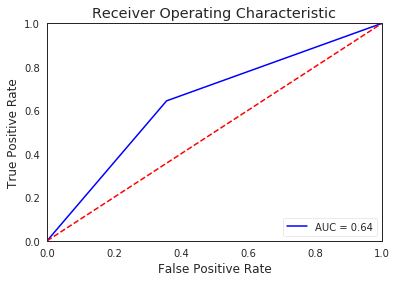

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 25.3min finished


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.6439
Confusion Matrix: 
 [[6492 3588]
 [3535 6385]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.644     0.646     10080
         1.0      0.640     0.644     0.642      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6438


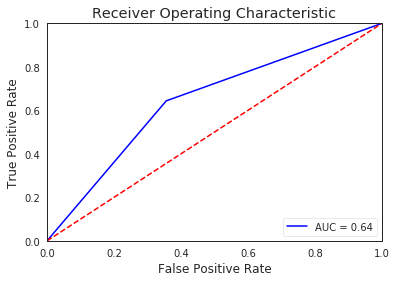

In [17]:
lr_clf = linear_model.LogisticRegression()
lr_clf.fit(train_x, train_y)
print(lr_clf)

# GridSearch 이전 기본 모델 출력
result_summary(lr_clf, test_x, test_y)

# GridSearch 시행

param_grid = {}
param_grid["C"] =  [0.001, 0.01, 0.1, 10]
param_grid["penalty"] =  ['l1','l2']
param_grid["max_iter"] = [100,150]

grid_lr_clf = GridSearchCV(lr_clf, param_grid, n_jobs=-1, cv=cv, verbose=1) 
grid_lr_clf.fit(train_x, train_y)
print(grid_lr_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(grid_lr_clf.best_estimator_, test_x, test_y) 

#### 8-1-2. LinearDiscriminantAnalysis
선형판별분석:데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Accuracy: 0.6440
Confusion Matrix: 
 [[6518 3562]
 [3558 6362]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.647     0.647     10080
         1.0      0.641     0.641     0.641      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6440


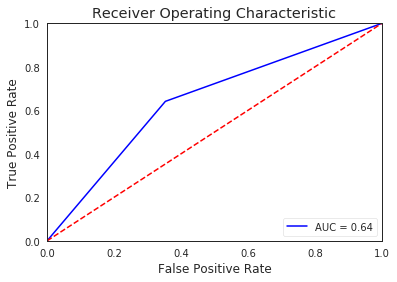

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.3s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Accuracy: 0.6440
Confusion Matrix: 
 [[6518 3562]
 [3558 6362]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.647     0.647     10080
         1.0      0.641     0.641     0.641      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6440


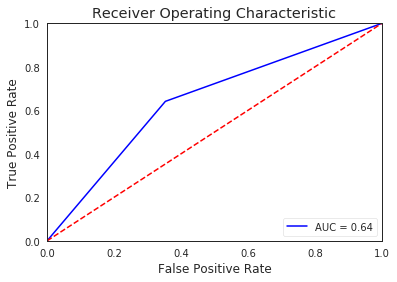

In [18]:
lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()
lda_clf.fit(train_x,train_y)
print(lda_clf)

# GridSearch 이전 기본 모델 출력
result_summary(lda_clf, test_x, test_y)

param_grid = {'solver':('svd','lsqr')}

grid_lda_clf = GridSearchCV(lda_clf, param_grid, n_jobs=-1, cv=cv, verbose=1)  
grid_lda_clf.fit(train_x, train_y)
print(grid_lda_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(grid_lda_clf.best_estimator_, test_x, test_y) 

#### 8-1-3. XGBoost Classifier 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 0.6455
Confusion Matrix: 
 [[6423 3657]
 [3432 6488]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.652     0.637     0.644     10080
         1.0      0.640     0.654     0.647      9920

    accuracy                          0.646     20000
   macro avg      0.646     0.646     0.646     20000
weighted avg      0.646     0.646     0.646     20000

roc_auc score is : 0.6456


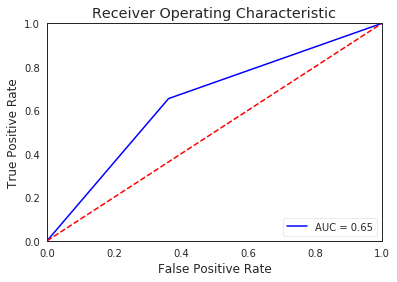

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 14.7min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 0.6450
Confusion Matrix: 
 [[6428 3652]
 [3448 6472]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.651     0.638     0.644     10080
         1.0      0.639     0.652     0.646      9920

    accuracy                          0.645     20000
   macro avg      0.645     0.645     0.645     20000
weighted avg      0.645     0.645     0.645     20000

roc_auc score is : 0.6451


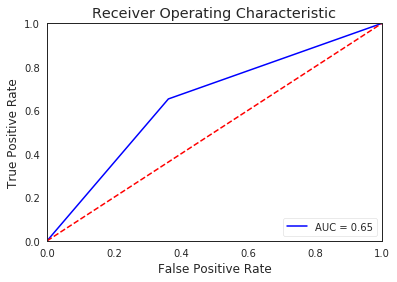

In [23]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_x,train_y)
print(xgb_clf)

# GridSearch 이전 기본 모델 출력
result_summary(xgb_clf, test_x, test_y)

param_grid = {}
param_grid["n_estimators"] =  [80, 100, 120]
param_grid["max_depth"] =  [3, 5]
param_grid["learning_rate"] = [0.01 ,0.1]

grid_xgb_clf = GridSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=cv, verbose=10)  
grid_xgb_clf.fit(train_x, train_y) 
print(grid_xgb_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(grid_xgb_clf.best_estimator_, test_x, test_y) 

#### 8-1-4. Gradient Boosting Classifier 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 73.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 85.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 100.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 116.1min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Accuracy: 0.6439
Confusion Matrix: 
 [[6444 3636]
 [3486 6434]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.649     0.639     0.644     10080
         1.0      0.639     0.649     0.644      9920

    accuracy                          0.644     20000
   macro a

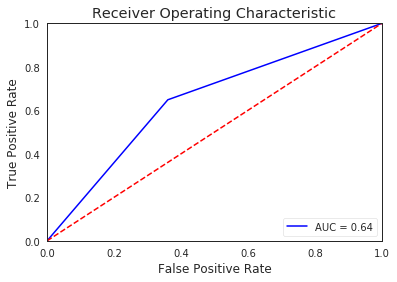

In [25]:
gb_clf = ensemble.GradientBoostingClassifier()
gb_clf.fit(train_x,train_y)
print(gb_clf)
result_summary(gb_clf, test_x, test_y)

# GridSearch 결과 결과값 향상 없음
param_grid = {}
param_grid["n_estimators"] =  [80, 100, 120]
param_grid["max_depth"] =  [3, 5]
param_grid["learning_rate"] = [0.01 ,0.1, 0.5]

grid_gb_clf = GridSearchCV(gb_clf, param_grid, n_jobs=-1, cv=cv, verbose=10)  
grid_gb_clf.fit(train_x, train_y) 
print(grid_gb_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(grid_gb_clf.best_estimator_, test_x, test_y)

Accuracy: 0.6439
Confusion Matrix: 
 [[6438 3642]
 [3481 6439]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.649     0.639     0.644     10080
         1.0      0.639     0.649     0.644      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6439


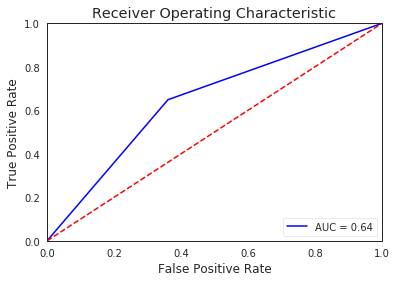

### 8-2. RandomizedSearchCV
###### GridSearch 최적값을 기본으로 앞뒤 쪽 RandomizedSearch로 최적값 산출

In [0]:
cv=5

#### 8-2-1. Logistic Regression

In [0]:
arams = {
          "C": st.uniform(8, 4.),
          "penalty" :  ['l2'],
          "max_iter" : st.randint(100, 150)
}

rs_lr_clf = RandomizedSearchCV(lr_clf, params, n_jobs=-1, cv=cv, verbose=1) 
rs_lr_clf.fit(train_x, train_y)
print(rs_lr_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(rs_lr_clf.best_estimator_, test_x, test_y)

# RandomizedSearchCV의 Logistic Regression Tuning 결과 : 0.6431에서 0.6436으로 성능 향상
lr_clf_best = linear_model.LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### 8-2-2. LinearDiscriminantAnalysis

In [0]:
# RandomizedSearchCV 결과 Accuracy: 0.6435로 동일하여 아래 코드 수행 안함
params = {
           "solver":['svd', 'lsqr'],
           "tol": st.uniform(1.0e-5, 1.0e-3),
        }
rs_lad_clf = RandomizedSearchCV(lda_clf, params, n_jobs=-1, cv=cv, verbose=1)  
rs_lad_clf.fit(train_x, train_y)
print(rs_lad_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(rs_lad_clf.best_estimator_, test_x, test_y)

lda_clf_best = discriminant_analysis.LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

#### 8-2-3. XGBoost Classifier 

In [0]:
# RandomizedSearchCV 결과 Accuracy: 0.6436에서 0.6446으로 성능 향상
one_to_left = st.beta(100, 1) 
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.9),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

rand_xgb_clf = RandomizedSearchCV(XGBClassifier(), params, n_jobs=-1, cv=cv, verbose=1)  
rand_xgb_clf.fit(train_x, train_y) 
print(rand_xgb_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(rand_xgb_clf.best_estimator_, test_x, test_y) 

# XGBoost Test
xgb_clf_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9954227711332254,
              gamma=4.4387091415399835, learning_rate=0.5931116776605618,
              max_delta_step=0, max_depth=31,
              min_child_weight=50.14224905929251, missing=None, n_estimators=20,
              n_jobs=1, nthread=None, nthreads=-1, objective='binary:logistic',
              random_state=0, reg_alpha=88.099034189603, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9978691522916254, verbosity=1)

#### 8-2-4. Gradient Boosting Classifier 

In [0]:
# 성능 동일
one_to_left = st.beta(100, 1)  
from_zero_positive = st.expon(0, 50)

params = {
    "loss":["deviance"],
    "learning_rate": st.uniform(0.01, 0.2),
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":st.randint(3, 8),
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":st.uniform(0.5, 0.5),
    }

rs_gb_clf = RandomizedSearchCV(gb_clf, params, n_jobs=-1, cv=cv, verbose=1)  
rs_gb_clf.fit(train_x, train_y) 
print(rs_gb_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(rs_gb_clf.best_estimator_, test_x, test_y) 

gb_clf_best = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## #9. Ensemble Models

In [0]:
# 앙상블을 위한 기능 구현
proba_lr = lr_clf_best.predict_proba(test_x)
proba_lda = lda_clf_best.predict_proba(test_x)
proba_xgb = xgb_clf_best.predict_proba(test_x)
proba_gb = gb_clf_best.predict_proba(test_x)

In [0]:
proba_results = pd.DataFrame(columns=['LR', 'LDA', 'XGB', 'GB', 'MLP', 'RealY'])
proba_results['LR'] = proba_lr[:,1]
proba_results['LDA'] = proba_lda[:,1]
proba_results['XGB'] = proba_xgb[:,1]
proba_results['MLP'] = proba_gb[:,1]
proba_results['RealY'] = test_y
proba_results

## #10. 확률(스코어) 모델 변환

In [0]:
# 확률 출력하는 함수 정의
def score_calc(model, real_x, real_y):
  prob_y = model.predict_proba(real_x)
  score_df = pd.DataFrame(columns=['prob_y', 'real_y'])
  # print(len(pred_y_xg[:,1]), len(test_y))

  score_df['prob_y'] = prob_y[:,1]
  score_df['real_y'] = test_y

  score_df = score_df.sort_values(by="prob_y", ascending=False)

  score_df["prob_bin"] = score_df['prob_y'].apply(lambda x: str(x)[:3])

  f={'prob_y':['count'], 'real_y':['sum']}
  score_final = score_df.groupby(["prob_bin"]).agg(f)
  score_final['accuracy'] = score_final['real_y'].values/score_final['prob_y'].values
  score_final['portion'] = score_final['real_y'].values/sum(score_final['real_y'].values)
  print(score_final)

  return score_final

In [0]:
print("Voting Classifier \n")
vc_score_df = score_calc(votingS,test_x, test_y)

print("-"*50)

print("Logistic Regression Classifier \n")
lr_score_df = score_calc(lr_clf,test_x, test_y)

print("-"*50)

print("LinearDiscriminantAnalysis Classifier \n")
lda_score_df = score_calc(lda_clf,test_x, test_y)

print("-"*50)

print("XGBClassifier Classifier \n")
xgb_score_df = score_calc(xgb_clf,test_x, test_y)

print("-"*50)

print("GradientBoostingClassifier \n")
gb_score_df = score_calc(gb_clf,test_x, test_y)

In [0]:
vc_score_df.plot.hist(x=vc_score_df.index.values, y=vc_score_df["prob_y","count"])